In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import textwrap
# adding entry into the specifications
# of the warnings filter.
warnings.filterwarnings('ignore', '.*do not.*', )
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm


In [322]:
data = pd.read_excel("WHO_Heat_Tool_dataset.xlsx")

In [323]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

def plot_service_availability_heatmap(df, services, title="Service Availability Heatmap"):
    """
    Plots a heatmap showing the availability of specified services across different hospital levels.
    Green represents unavailable (0), Orange represents available (1).
    
    Referral/Teaching Hospitals reflect actual data values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing hospital data.
    services (list): A list of services to visualize.
    title (str): The title of the heatmap.

    Returns:
    None
    """
    # Get unique hospital levels in sorted order
    hospital_levels = sorted(df['Hospital level'].unique())

    # Create figure for subplots
    fig, axes = plt.subplots(1, len(hospital_levels), figsize=(6 * len(hospital_levels), 6), sharey=True)
    fig.suptitle(title, fontsize=16, fontweight='bold')  # Set the title of the figure

    # Ensure axes is iterable when there's only one hospital level
    if len(hospital_levels) == 1:
        axes = [axes]

    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        # Filter data for the current hospital level
        level_data = df[df['Hospital level'] == level]
        heatmap_data = level_data.set_index("Hospital name")[services].T.fillna(0)
        binary_data = (heatmap_data > 0).astype(int)  # Convert to binary (1=available, 0=unavailable)

        # Plot heatmap with actual values for Referral/Teaching Hospitals
        sns.heatmap(binary_data, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black",
                    xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index,
                    cmap=["forestgreen", "orangered"], vmin=0, vmax=1, annot=False)

        # Set title for each hospital level
        axes[i].set_title(f"{level}")

        # Rotate x-axis labels for readability
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

    # Create a custom legend with **switched colors**
    green_patch = mpatches.Patch(color='forestgreen', label='Unavailable')
    orange_patch = mpatches.Patch(color='orangered', label='Available')

    # Add legend below the plots
    plt.figlegend(handles=[green_patch, orange_patch], loc="lower center", ncol=2, title="Legend", fontsize=8)
    plt.subplots_adjust(bottom=0.3, top=0.9, wspace=0.1)
    plt.show()
    
    
import pandas as pd
from tabulate import tabulate

def transform_service_availability(df, service_columns):
    """Transforms service availability scores (100, 50, 0) into categorical labels."""
    mapping = {100: 'Fully Available', 50: 'Partially Available', 0: 'Unavailable'}
    for col in service_columns:
        if col in df.columns:
            df[col] = df[col].replace(mapping)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df

def summarize_service_availability(df, service_columns):
    """Summarizes service availability counts and percentages."""

    overall_summary = {}
    level_summary = {}

    for service in service_columns:
        if service not in df.columns:
            print(f"Warning: Column '{service}' not found in DataFrame.")
            continue  # Skip to the next service

        overall_counts = df[service].value_counts().to_dict()
        overall_summary[service] = overall_counts

        for level in df['Hospital level'].unique():
            level_df = df[df['Hospital level'] == level]
            level_counts = level_df[service].value_counts().to_dict()

            if level not in level_summary:
                level_summary[level] = {}
            level_summary[level][service] = level_counts

    return overall_summary, level_summary


def format_summary_table(summary_data):
    """Formats summary data with counts and percentages."""

    formatted_table = {}
    for service, counts in summary_data.items():
        total = sum(counts.values()) if counts else 0  # Handle cases where counts might be empty
        formatted_row = {}
        for availability, count in counts.items():
            percentage = (count / total) * 100 if total > 0 else 0
            formatted_row[availability] = f"({count} - {percentage:.1f}%)"
        formatted_table[service] = formatted_row

    return pd.DataFrame.from_dict(formatted_table, orient='index').fillna("(0 - 0.0%)") # Fill missing with 0


def display_tables(overall_formatted, level_formatted):
    """Displays tables using tabulate."""
    print("\nOverall Service Availability Summary:")
    print(tabulate(overall_formatted, headers='keys', tablefmt='pretty'))

    print("\nService Availability Summary by Hospital Level:")
    for level, df in level_formatted.items():
        print(f"\nHospital Level: {level}")
        print(tabulate(df, headers='keys', tablefmt='pretty'))


def export_to_excel(overall_formatted, level_formatted):
    """Exports to Excel, sanitizing sheet names."""
    with pd.ExcelWriter('service_availability_summary.xlsx') as writer:
        overall_formatted.to_excel(writer, sheet_name='Overall Summary')

        for level, df in level_formatted.items():
            # Sanitize the sheet name by replacing invalid characters
            safe_sheet_name = level.replace("/", "_").replace("\\", "_")  # Replace / and \ with _
            df.to_excel(writer, sheet_name=f'Level {safe_sheet_name}')



In [324]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_service_availability_heatmap(df, services, title):
    """
    Generate heatmaps for each hospital level showing service availability.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing 'Unit name', 'Hospital name', and service availability columns.
    services (list): List of services to include in the heatmap.
    title (str): Title of the graph.
    """
    
    # Replace service values: 3 -> 100, 2 -> 50, 1 -> 0
    df[services] = df[services].replace({3: 100, 2: 50, 1: 0})
    
    # Unique hospital levels
    hospital_levels = df['Hospital level'].unique()
    
    # Create figure for subplots
    fig, axes = plt.subplots(1, len(hospital_levels), figsize=(6 * len(hospital_levels), 6), sharey=True)
    
    # Define the custom colormap: Red (0), Yellow (50), Green (100)
    colors = ["red", "yellow", "green"]
    cmap = ListedColormap(colors)
    bounds = [0, 25, 75, 100]  # Define threshold values
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Ensure axes is iterable even if there's only one subplot
    if len(hospital_levels) == 1:
        axes = [axes]
    
    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        # Filter data for the current hospital level
        level_data = df[df['Hospital level'] == level]
        
        # Pivot table (Hospitals as columns, Services as rows)
        heatmap_data = level_data.set_index("Hospital name")[services].T
        
        # Plot heatmap with custom colors
        sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black")
        
        # Title and labels
        axes[i].set_title(f"{level}")
        # axes[i].set_xlabel("Hospital Name")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")
    
    # Set common y-axis label
    # axes[0].set_ylabel("Services")
    
    # Create a custom legend
    red_patch = mpatches.Patch(color='red', label='Unavailable')
    yellow_patch = mpatches.Patch(color='yellow', label='Partially Available')
    green_patch = mpatches.Patch(color='green', label='Fully Available')
    
    # Add legend below the plots
    plt.figlegend(handles=[red_patch, yellow_patch, green_patch], loc="lower center", ncol=3, title="Legend", fontsize=8)
    
    # Adjust layout to fit legend
    plt.subplots_adjust(bottom=0.3)
    
    # Set main title
    plt.suptitle(title, fontsize=14, fontweight='bold')
    
    plt.show()


In [325]:
import pandas as pd

# Creating a DataFrame
vital_data = pd.DataFrame()
vital_data['Hospital name'] = data["hospital_name_sign"]

# Hospital mapping dictionary
hospital_mapping = {
    1: "CHUK",
    2: "Masaka DH",
    3: "Nyamata DH",
    4: "Kirehe DH",
    5: "Butaro DH",
    6: "Nemba DH",
    7: "CHUB",
    8: "Kabutare DH",
    9: "Kibogora DH",
    10: "Gisenyi DH"
}

hospital_levels = {
    "CHUK": "Referral/Teaching Hospital",
    "Masaka DH": "District Hospital",
    "Nyamata DH": "Level 2 Teaching Hospital",
    "Kirehe DH": "District Hospital",
    "Butaro DH": "Level 2 Teaching Hospital",
    "Nemba DH": "District Hospital",
    "CHUB": "Referral/Teaching Hospital",
    "Kabutare DH": "District Hospital",
    "Kibogora DH": "Level 2 Teaching Hospital",
    "Gisenyi DH": "District Hospital"
}

# Replace numeric values with hospital names
vital_data['Hospital name'] = vital_data['Hospital name'].map(hospital_mapping)

# Ensure hospital levels are correctly mapped
vital_data['Hospital level'] = vital_data['Hospital name'].map(hospital_levels)



In [326]:
vital_data['Vital signs measured in the triage area'] = data["vital_signs_rate"]
vital_data['Vital signs measured in the Emergency Unit'] = data["emergency_unit_signs"]
vital_data['Vital signs measured intermittently in the neonatal high dependency unit'] = data["dependency_unit_signs"]
vital_data['Vital signs measured continuously in the neonatal high dependency unit'] = data["neonatal_high_unit"]
vital_data['Vital signs measured intermittently in the pediatric high dependency unit'] = data["pediatric_high_unit"]
vital_data['Vital signs measured continuously in the pediatric high dependency unit'] = data["continous_measured_signs"]

# vital_data['Antibiotic administration for open fracture'] = data["antibiotic"]
# vital_data['Tetanus vaccination or IVIg as appropriate'] = data["tetanus"]
# vital_data['Rabies vaccination or IVIg as appropriate'] = data["rabies"]

In [327]:
vital_data.columns

Index(['Hospital name', 'Hospital level',
       'Vital signs measured in the triage area',
       'Vital signs measured in the Emergency Unit',
       'Vital signs measured intermittently in the neonatal high dependency unit',
       'Vital signs measured continuously in the neonatal high dependency unit',
       'Vital signs measured intermittently in the pediatric high dependency unit',
       'Vital signs measured continuously in the pediatric high dependency unit'],
      dtype='object')

In [328]:
vital_data

,Hospital name,Hospital level,Vital signs measured in the triage area,Vital signs measured in the Emergency Unit,Vital signs measured intermittently in the neonatal high dependency unit,Vital signs measured continuously in the neonatal high dependency unit,Vital signs measured intermittently in the pediatric high dependency unit,Vital signs measured continuously in the pediatric high dependency unit
0,Masaka DH,District Hospital,3,3,3,1,3,1
1,Nemba DH,District Hospital,3,3,3,1,3,1
2,Nyamata DH,Level 2 Teaching Hospital,3,3,3,1,3,1
3,Kabutare DH,District Hospital,3,3,3,1,1,1
4,Kirehe DH,District Hospital,3,3,3,1,2,1
5,Butaro DH,Level 2 Teaching Hospital,3,3,3,1,3,1
6,Kibogora DH,Level 2 Teaching Hospital,3,3,3,1,3,1
7,Gisenyi DH,District Hospital,3,3,3,1,3,1
8,CHUK,Referral/Teaching Hospital,3,3,3,2,3,2
9,CHUB,Referral/Teaching Hospital,3,3,3,2,3,2


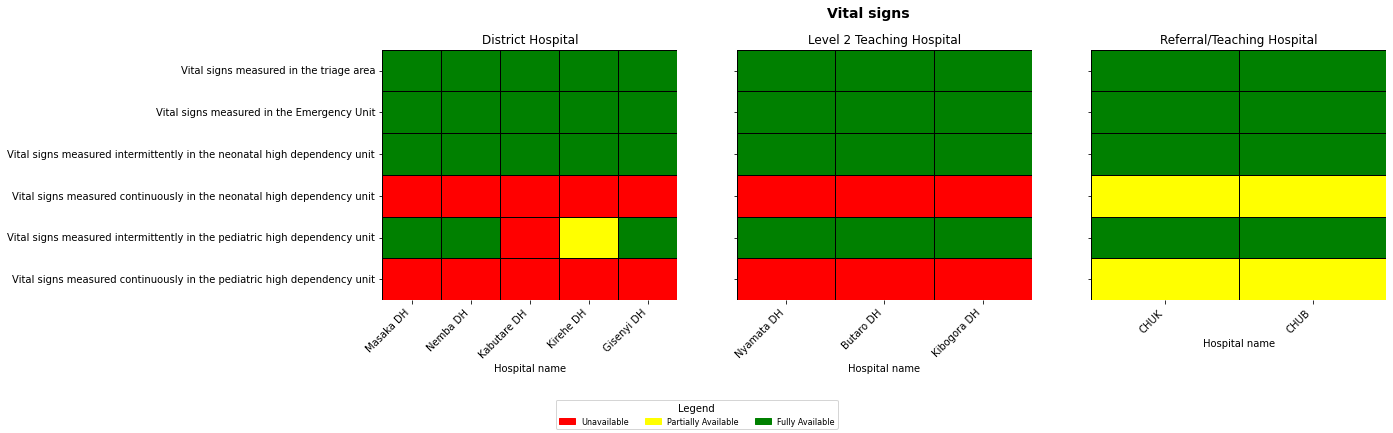

In [329]:
plot_service_availability_heatmap(vital_data, ['Vital signs measured in the triage area',
       'Vital signs measured in the Emergency Unit',
       'Vital signs measured intermittently in the neonatal high dependency unit',
       'Vital signs measured continuously in the neonatal high dependency unit',
       'Vital signs measured intermittently in the pediatric high dependency unit',
       'Vital signs measured continuously in the pediatric high dependency unit'
       ],"Vital signs")

In [330]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd

def plot_service_availability_heatmap(df, services, no_info_hospitals=[], title="Service Availability Heatmap"):
    """
    Plots a heatmap showing the availability of specified services across different hospital levels.
    - Green (white) represents unavailable (0),
    - Orange represents available (1),
    - Gray represents hospitals with no given info.

    Parameters:
    df (pd.DataFrame): The DataFrame containing hospital data.
    services (list): A list of services to visualize.
    no_info_hospitals (list): A list of hospital names with no available data.
    title (str): The title of the heatmap.

    Returns:
    None
    """
    # Get unique hospital levels in sorted order
    hospital_levels = sorted(df['Hospital level'].unique())

    # Create figure for subplots
    fig, axes = plt.subplots(1, len(hospital_levels), figsize=(6 * len(hospital_levels), 6), sharey=True)
    fig.suptitle(title, fontsize=16, fontweight='bold')  # Set the title of the figure

    # Ensure axes is iterable when there's only one hospital level
    if len(hospital_levels) == 1:
        axes = [axes]

    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        # Filter data for the current hospital level
        level_data = df[df['Hospital level'] == level]
        heatmap_data = level_data.set_index("Hospital name")[services].T.fillna(0)
        binary_data = (heatmap_data > 0).astype(int)  # Convert to binary (1=available, 0=unavailable)

        # Identify hospitals with no given info
        for hospital in no_info_hospitals:
            if hospital in binary_data.columns:
                binary_data[hospital] = -1  # Mark hospitals with no given info as -1

        # Define a custom colormap
        cmap = {0: "white", 1: "orangered", -1: "gray"}
        sns.heatmap(binary_data, cbar=False, ax=axes[i], linewidths=0.5, linecolor="white",
                    xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index,
                    cmap=[cmap[val] for val in sorted(cmap.keys())], vmin=-1, vmax=1, annot=False)

        # Set title for each hospital level
        axes[i].set_title(f"{level}")
        
        # Rotate x-axis labels for readability
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

    # Create a custom legend with switched colors
    white_patch = mpatches.Patch(color='white', label='Non-identified Item')
    orange_patch = mpatches.Patch(color='orangered', label='Identified Missing Item')
    gray_patch = mpatches.Patch(color='gray', label='No given info')

    # Add legend below the plots
    plt.figlegend(handles=[white_patch, orange_patch, gray_patch], loc="lower center", ncol=3, title="Legend", fontsize=8)
    plt.subplots_adjust(bottom=0.3, top=0.9, wspace=0.1)
    plt.show()


In [331]:
vital_data['Infrastructure'] = data["chest_tube_choices___1"]
vital_data['Absent Equipment'] = data["chest_tube_choices___2"]
vital_data['Broken Equipment'] = data["chest_tube_choices___3"]
vital_data['Stockout (Supplies)'] = data["chest_tube_choices___4"]
vital_data['Training'] = data["chest_tube_choices___5"]
vital_data['Personnel'] = data["chest_tube_choices___6"]
vital_data['User fees'] = data["chest_tube_choices___7"]
vital_data['Opening Hours'] = data["chest_tube_choices___8"]
vital_data['Others'] = data["chest_tube_choices___9"]

In [332]:
vital_data.columns

Index(['Hospital name', 'Hospital level',
       'Vital signs measured in the triage area',
       'Vital signs measured in the Emergency Unit',
       'Vital signs measured intermittently in the neonatal high dependency unit',
       'Vital signs measured continuously in the neonatal high dependency unit',
       'Vital signs measured intermittently in the pediatric high dependency unit',
       'Vital signs measured continuously in the pediatric high dependency unit',
       'Infrastructure', 'Absent Equipment', 'Broken Equipment',
       'Stockout (Supplies)', 'Training', 'Personnel', 'User fees',
       'Opening Hours', 'Others'],
      dtype='object')

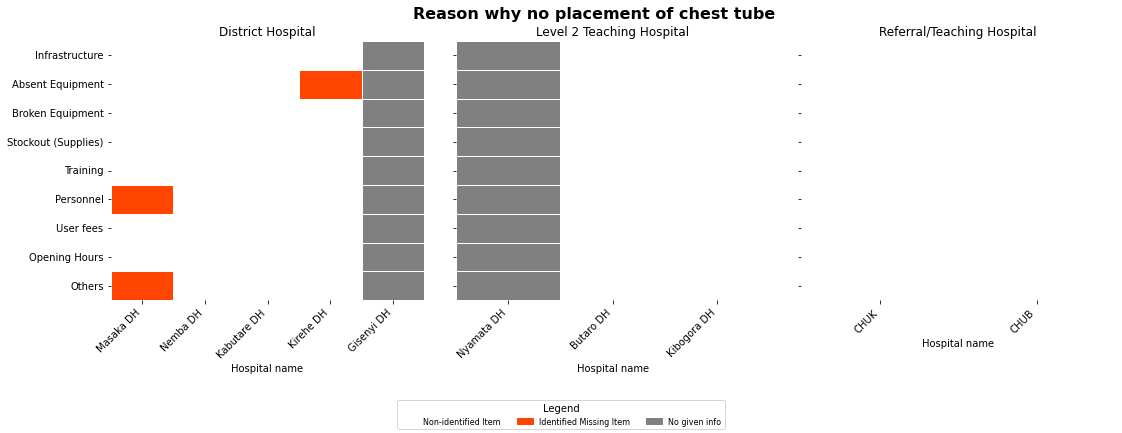

In [333]:
plot_service_availability_heatmap(vital_data, ['Infrastructure', 'Absent Equipment', 'Broken Equipment',
       'Stockout (Supplies)', 'Training', 'Personnel', 'User fees',
       'Opening Hours', 'Others'],["Gisenyi DH", "Nyamata DH", "Butaro SH"],"Reason why no placement of chest tube ")

#### 3. Clinical Services

In [334]:
import pandas as pd

# Creating a DataFrame
clin_data = pd.DataFrame()
clin_data['Hospital name'] = data["hospital_name_clin"]

# Hospital mapping dictionary
hospital_mapping = {
    1: "CHUK",
    2: "Masaka DH",
    3: "Nyamata DH",
    4: "Kirehe DH",
    5: "Butaro DH",
    6: "Nemba DH",
    7: "CHUB",
    8: "Kabutare DH",
    9: "Kibogora DH",
    10: "Gisenyi DH"
}

hospital_levels = {
    "CHUK": "Referral/Teaching Hospital",
    "Masaka DH": "District Hospital",
    "Nyamata DH": "Level 2 Teaching Hospital",
    "Kirehe DH": "District Hospital",
    "Butaro DH": "Level 2 Teaching Hospital",
    "Nemba DH": "District Hospital",
    "CHUB": "Referral/Teaching Hospital",
    "Kabutare DH": "District Hospital",
    "Kibogora DH": "Level 2 Teaching Hospital",
    "Gisenyi DH": "District Hospital"
}

# Replace numeric values with hospital names
clin_data['Hospital name'] = clin_data['Hospital name'].map(hospital_mapping)

# Ensure hospital levels are correctly mapped
clin_data['Hospital level'] = clin_data['Hospital name'].map(hospital_levels)

In [335]:
clin_data["Are there regulations and/or protocols mandating that critically ill or injured patients are clinically triaged prior to being required to register?"] = data["mandating_regulations"]
clin_data["Does the facility require payment prior to provision of initial emergency care?"] = data['facility_payment']
clin_data["Are vital signs measured in dedicated triage area? "] = data['vital_signs']
clin_data["Does this facility have a formal triage system available"] = data['formal_triage']
clin_data["Is this formal triage system in actual use?"] = data['triage_system']
clin_data["Have all personnel that use the formal triage system been trained to use it?"] = data['personnel']
clin_data["Are there time targets for each triage category (e.g., YELLOW – seen by provider within 2 hours)? "] = data['triage_targets']
clin_data["If there are time targets, is compliance tracked regularly?"] = data['time_targets']
clin_data["Are there specific triage protocols for children <2 years of age?"] = data['triage_protocols']
clin_data["Protocol for systematic triage that ensures patients are seen in order of severity of their conditions"] = data['protocol_for_systematic']
clin_data["Clear protocol for communication with hospital administration during times of overcrowding "] = data['clear_protocol']


clin_data["Protocol for initial approach to ABCDs"] = data['protocol_for_initial_appro']
clin_data["Trauma care checklist"] = data['trauma_care_checklist']
clin_data["Medical resuscitation checklist"] = data['medical_resuscitation_chec']
clin_data["Protocol for neonatal resuscitation (Integrated in neonatal protocol)"] = data['protocol_for_neonatal_resu']
clin_data["Protocol for volume/fluid  resuscitation of children under 5 years"] = data['protocol_for_volume_fluid']
clin_data["Protocol for adjusting interventions for malnourished patients"] = data['protocol_for_adjusting_int']
clin_data["Protocol for post-exposure prevention of STI/HIV, , counselling"] = data['protocol_for_post_exposure']

clin_data["Asthma exacerbation"] = data['asthma_exacerbation']
clin_data["Pneumonia"] = data['pneumonia']
clin_data["Sepsis"] = data['sepsis']
clin_data["Diabetic ketoacidosis"] = data['diabetic_ketoacidosis']
clin_data["Burn care management "] = data['burn_care_management']
clin_data["Other:"] = data['other_other']




clin_data["Acuity-based internal transfer protocols/policy for NICU/HDU"] = data['acuity_based_internal_transfer']
clin_data["Protocol /Policy for timely disposition from the emergency unit"] = data['protocol_for_timely_disposition']
clin_data["Protocol/policy for conveying information about discharge or disposition to the patient "] = data['protocol_for_conveying_ifo']
clin_data["Hand-over protocols/policies when transferring patients from one care provider to another "] = data['hand_over_protocols']
clin_data["Condition-specific transfer or referral protocols/policies"] = data['condition_specific_transfe']
clin_data["Communication policy with receiving facility prior to transfer of patients with emergency conditions "] = data['communication_policy_with']
clin_data["Communication with receiving facility prior to transfer of patients"] = data['condition_specific_transfe']
clin_data["Process to provide documentation of initial assessment, treatments provided, and condition"] = data['process_to_provide_documen']


clin_data["Infection prevention and control protocols/policy"] = data['infection_prevention_and_c']
clin_data["Protocol/policy for post exposure prophylaxis for health care workers "] = data['protocol_policy_for_post_e']
clin_data["Security protocols/policies to protect staff, patients, and infrastructure from violence."] = data['security_protocols_policie']
clin_data["Protocol/policy for managing hazardous exposures (including designated decontamination area)"] = data['protocol_policy_for_managi']
clin_data["Containment and disposal of sharps and biomedical waste"] = data['containment_and_disposal_o']
clin_data["Plan to ensure emergency unit staff and patient safety if an incident occurs within the emergency unit (including space, transport, communications)"] = data['plan_to_ensure_emergency_u']
clin_data = clin_data.replace({1: "Yes", 2: "No"})
clin_data

,Hospital name,Hospital level,Are there regulations and/or protocols mandating that critically ill or injured patients are clinically triaged prior to being required to register?,Does the facility require payment prior to provision of initial emergency care?,Are vital signs measured in dedicated triage area?,Does this facility have a formal triage system available,Is this formal triage system in actual use?,Have all personnel that use the formal triage system been trained to use it?,"Are there time targets for each triage category (e.g., YELLOW – seen by provider within 2 hours)?","If there are time targets, is compliance tracked regularly?",...,Condition-specific transfer or referral protocols/policies,Communication policy with receiving facility prior to transfer of patients with emergency conditions,Communication with receiving facility prior to transfer of patients,"Process to provide documentation of initial assessment, treatments provided, and condition",Infection prevention and control protocols/policy,Protocol/policy for post exposure prophylaxis for health care workers,"Security protocols/policies to protect staff, patients, and infrastructure from violence.",Protocol/policy for managing hazardous exposures (including designated decontamination area),Containment and disposal of sharps and biomedical waste,"Plan to ensure emergency unit staff and patient safety if an incident occurs within the emergency unit (including space, transport, communications)"
0,Masaka DH,District Hospital,Yes,No,Yes,Yes,Yes,Yes,Yes,No,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,Nemba DH,District Hospital,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,Nyamata DH,Level 2 Teaching Hospital,Yes,No,Yes,No,No,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3,Kabutare DH,District Hospital,Yes,No,Yes,Yes,Yes,Yes,Yes,No,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,Kirehe DH,District Hospital,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5,Butaro DH,Level 2 Teaching Hospital,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6,Kibogora DH,Level 2 Teaching Hospital,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
7,Gisenyi DH,District Hospital,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
8,CHUK,Referral/Teaching Hospital,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
9,CHUB,Referral/Teaching Hospital,Yes,No,Yes,Yes,Yes,No,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


#### Infrastrucures and essential equipment

In [336]:
   
import pandas as pd
from tabulate import tabulate

def transform_service_availability(df, service_columns):
    """Transforms service availability scores (100, 50, 0) into categorical labels."""
    mapping = {100: 'Fully Available', 50: 'Partially Available', 0: 'Unavailable'}
    for col in service_columns:
        if col in df.columns:
            df[col] = df[col].replace(mapping)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df

def summarize_service_availability(df, service_columns):
    """Summarizes service availability counts and percentages."""

    overall_summary = {}
    level_summary = {}

    for service in service_columns:
        if service not in df.columns:
            print(f"Warning: Column '{service}' not found in DataFrame.")
            continue  # Skip to the next service

        overall_counts = df[service].value_counts().to_dict()
        overall_summary[service] = overall_counts

        for level in df['Hospital level'].unique():
            level_df = df[df['Hospital level'] == level]
            level_counts = level_df[service].value_counts().to_dict()

            if level not in level_summary:
                level_summary[level] = {}
            level_summary[level][service] = level_counts

    return overall_summary, level_summary


def format_summary_table(summary_data):
    """Formats summary data with counts and percentages."""

    formatted_table = {}
    for service, counts in summary_data.items():
        total = sum(counts.values()) if counts else 0  # Handle cases where counts might be empty
        formatted_row = {}
        for availability, count in counts.items():
            percentage = (count / total) * 100 if total > 0 else 0
            formatted_row[availability] = f"({count} - {percentage:.1f}%)"
        formatted_table[service] = formatted_row

    return pd.DataFrame.from_dict(formatted_table, orient='index').fillna("(0 - 0.0%)") # Fill missing with 0


def display_tables(overall_formatted, level_formatted):
    """Displays tables using tabulate."""
    print("\nOverall Service Availability Summary:")
    print(tabulate(overall_formatted, headers='keys', tablefmt='pretty'))

    print("\nService Availability Summary by Hospital Level:")
    for level, df in level_formatted.items():
        print(f"\nHospital Level: {level}")
        print(tabulate(df, headers='keys', tablefmt='pretty'))


def export_to_excel(overall_formatted, level_formatted):
    """Exports to Excel, sanitizing sheet names."""
    with pd.ExcelWriter('infrastructure_availability_summary.xlsx') as writer:
        overall_formatted.to_excel(writer, sheet_name='Overall Summary')

        for level, df in level_formatted.items():
            # Sanitize the sheet name by replacing invalid characters
            safe_sheet_name = level.replace("/", "_").replace("\\", "_")  # Replace / and \ with _
            df.to_excel(writer, sheet_name=f'Level {safe_sheet_name}')



In [337]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_hospital_service_heatmaps(cons_data, services):
    """
    Generates heatmaps showing service availability across different hospital levels.
    
    Parameters:
    cons_data (DataFrame): The dataset containing hospital service availability.
    services (list): List of service column names to be visualized.
    """
    # Create figure for subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Unique hospital levels
    hospital_levels = cons_data['Unit name'].unique()
    
    # Define the custom colormap: Red (0), Yellow (50), Green (100)
    colors = ["red", "yellow", "green"]
    cmap = ListedColormap(colors)
    bounds = [0, 25, 75, 100]  # Define threshold values
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        # Filter data for the current hospital level
        level_data = cons_data[cons_data['Unit name'] == level]
        
        # Pivot table (Hospitals as columns, Services as rows)
        heatmap_data = level_data.set_index("Hospital name")[services].T
        
        # Plot heatmap with custom colors
        sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black")
        
        # Title and labels
        axes[i].set_title(f" {level}")
        axes[i].set_xlabel("Hospital Name")
    
    # Set common y-axis label
    axes[0].set_ylabel("Services")
    
    # Create a custom legend
    red_patch = mpatches.Patch(color='red', label='Unavailable (0%)')
    yellow_patch = mpatches.Patch(color='yellow', label='Partially Available (50%)')
    green_patch = mpatches.Patch(color='green', label='Fully Available (100%)')
    
    # Add legend below the plots
    plt.figlegend(handles=[red_patch, yellow_patch, green_patch], loc="lower center", ncol=3, title="Legend", fontsize=8)
    
    # Adjust layout to fit legend
    plt.subplots_adjust(bottom=0.2)
    
    # Show plot
    plt.show()



def plot_service_availability_heatmap2(df, services, title):
    """
    Generate heatmaps for service availability across different hospital levels.
    
    Parameters:
    df (pd.DataFrame): Dataframe containing hospital data with columns 'Hospital level', 'Hospital name', and service availability.
    services (list): List of service columns to visualize.
    title (str): Title of the overall plot.
    """
    hospital_levels = sorted(df['Hospital level'].unique())
    
    # Create figure for subplots
    fig, axes = plt.subplots(1, len(hospital_levels), figsize=(6 * len(hospital_levels), 6), sharey=True)
    
    if len(hospital_levels) == 1:
        axes = [axes]  # Ensure axes is always iterable
    
    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        level_data = df[df['Hospital level'] == level]
        heatmap_data = level_data.set_index("Hospital name")[services].T.fillna(0)
        binary_data = (heatmap_data > 0).astype(int)
        
        # Ensure Referral/Teaching Hospitals appear fully green
        if level == "Referral/Teaching Hospital":
            binary_data[:] = 1
        
        # Plot heatmap without numbers inside
        sns.heatmap(binary_data, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black",
                    xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index,
                    cmap=["orangered", "forestgreen"], vmin=0, vmax=1, annot=False)
        
        axes[i].set_title(level)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="right")
    
    # Create a custom legend
    red_patch = mpatches.Patch(color='orangered', label='Unavailable')
    green_patch = mpatches.Patch(color='forestgreen', label='Available')
    
    # Add legend below the plots
    plt.figlegend(handles=[green_patch, red_patch], loc="lower center", ncol=2, title="Legend", fontsize=8)
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.subplots_adjust(bottom=0.3, top=0.9, wspace=0.1)
    plt.show()


In [338]:
infra_data = pd.read_excel("Infrastructure_data.xlsx")
infra_data2 = pd.read_excel("Infrastructure_data.xlsx", sheet_name="Sheet3")
infra_data3 = pd.read_excel("Infrastructure222.xlsx")

In [339]:
infra_data = infra_data[infra_data['Unit name'] == 'Pediatric Unit']

In [340]:
service_cols = ['Clean, running water ', 
       'Electricity source ', 
       'Designated telephone for communicating with other facilities',
       'Isolation room for infectious diseases ', 
       'Easy physical access to emergency unit for those requiring a wheelchair ', 'Designated waiting area ', 'Designated triage area ', 'Designated resuscitation area ', 'Personal protective equipment ',
       'Proportion of beds with continuous electronic cardiac monitoring in emergency unit ',
       'Crash trolley or code cart ', 'Defibrillator available in emergency unit ',
       'Rapid access to a transport ambulance ', 
       'Access to dedicated staff work area ',
       'Is there access to storage space within the emergency unit',
       'Access to toilet facilities for patients and staff , within the unit',
       'Access to handwashing facilities in each patient care area with supplies-soap, water, towel) ',
       'System for stocking, managing, and dispensing medications in emergency unit ',]

data = transform_service_availability(infra_data, service_cols)
overall_summary, level_summary = summarize_service_availability(infra_data, service_cols)

overall_formatted = format_summary_table(overall_summary)
level_formatted = {level: format_summary_table(data) for level, data in level_summary.items()}

display_tables(overall_formatted, level_formatted)
export_to_excel(overall_formatted, level_formatted)



Overall Service Availability Summary:
+----------------------------------------------------------------------------------------------+-----------------+---------------------+-------------+
|                                                                                              | Fully Available | Partially Available | Unavailable |
+----------------------------------------------------------------------------------------------+-----------------+---------------------+-------------+
|                                     Clean, running water                                     |   (8 - 80.0%)   |     (2 - 20.0%)     | (0 - 0.0%)  |
|                                      Electricity source                                      |  (10 - 100.0%)  |     (0 - 0.0%)      | (0 - 0.0%)  |
|                 Designated telephone for communicating with other facilities                 |  (10 - 100.0%)  |     (0 - 0.0%)      | (0 - 0.0%)  |
|                            Isolation room for infecti

C:\Users\ishim\AppData\Local\Temp\ipykernel_24340\2320059407.py:67: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  with pd.ExcelWriter('infrastructure_availability_summary.xlsx') as writer:


PermissionError: [Errno 13] Permission denied: 'infrastructure_availability_summary.xlsx'

#### 2. Human resources

In [ ]:
hr_data = pd.read_excel("Human resource data.xlsx")

In [ ]:
hr_data

,hospital_name,outpatient visits per year,inpatient admissions per year,emergency_units,emergency care beds,Nurses/nurse midwives,Medical officers,pediatric_emergency_doctor,Neonatologist,Pediatrician
0,Masaka DH,7651,3490,2571.0,27,42,18,0,0,4
1,Nemba DH,1853,1490,2226.0,7,28,22,0,0,2
2,Nyamata DH,2745,3303,1581.0,5,30,3,0,0,3
3,Kabutare DH,1509,1751,1673.0,10,32,39,0,0,2
4,Kirehe DH,1465,1212,2864.0,10,27,16,0,3,2
5,Butaro DH,1392,1784,1965.0,19,34,15,0,2,2
6,Kibogora DH,1832,3262,2938.0,12,35,3,0,0,2
7,Gisenyi DH,3373,3408,NaN,23,53,15,0,0,1
8,CHUK,9132,1872,2052.0,11,97,12,0,4,2
9,CHUB,10820,1699,NaN,3,64,3,0,0,15


In [ ]:
import pandas as pd

def calculate_inpatient_ratios_pivot(df, staff_services, inpatient_col, output_filename="inpatient_ratios.xlsx"):
    """
    Calculates inpatient ratios, pivots, and exports to Excel.

    Args:
        df: Pandas DataFrame.
        staff_services: List of staff service columns.
        inpatient_col: Inpatient admissions column name.
        output_filename: Name of the Excel file to export to.

    Returns:
        Pandas DataFrame or None if error.  Also exports to Excel.
    """

    if inpatient_col not in df.columns:
        print(f"Error: Inpatient column '{inpatient_col}' not found in DataFrame.")
        return None

    results = []

    for facility in df['hospital_name'].unique():
        facility_df = df[df['hospital_name'] == facility]
        total_inpatients = facility_df[inpatient_col].sum()

        row = {'Hospital name': facility}
        if total_inpatients == 0:
            for service in staff_services:
                row[f"{service} to inpatient ratio"] = "N/A (No Inpatients)"
            results.append(row)
            continue

        for service in staff_services:
            if service in facility_df.columns:
                total_staff = facility_df[service].sum()
                if total_staff == 0:
                    ratio = "N/A (No Staff)"
                else:
                    ratio = round(total_inpatients / total_staff) if total_staff > 0 else "N/A"
                row[f"{service} "] = ratio
            else:
                print(f"Warning: Staff service '{service}' not found in DataFrame for facility '{facility}'.")
                row[f"{service} to inpatient ratio"] = "N/A (Column Missing)"

        results.append(row)

    results_df = pd.DataFrame(results).set_index('Hospital name')

    # Export to Excel:
    try:
        results_df.to_excel(output_filename)
        print(f"Inpatient ratios exported to {output_filename}")
    except Exception as e:
        print(f"Error exporting to Excel: {e}")
        return None  # Return None if export fails

    return results_df  # Return DataFrame even if export is successful


In [ ]:
calculate_inpatient_ratios_pivot(df = hr_data, staff_services = ["Nurses/nurse midwives","Medical officers","pediatric_emergency_doctor","Neonatologist","Pediatrician","emergency care bed"], inpatient_col = "emergency_units",output_filename="emergen_beds.xlsx")

Inpatient ratios exported to emergen_beds.xlsx


C:\Users\ishim\AppData\Local\Temp\ipykernel_24340\3890389509.py:52: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  results_df.to_excel(output_filename)


,Nurses/nurse midwives,Medical officers,pediatric_emergency_doctor,Neonatologist,Pediatrician,emergency care bed to inpatient ratio,Nurses/nurse midwives to inpatient ratio,Medical officers to inpatient ratio,pediatric_emergency_doctor to inpatient ratio,Neonatologist to inpatient ratio,Pediatrician to inpatient ratio
Hospital name,,,,,,,,,,,
Masaka DH,61.0,143.0,N/A (No Staff),N/A (No Staff),643.0,N/A (Column Missing),NaN,NaN,NaN,NaN,NaN
Nemba DH,80.0,101.0,N/A (No Staff),N/A (No Staff),1113.0,N/A (Column Missing),NaN,NaN,NaN,NaN,NaN
Nyamata DH,53.0,527.0,N/A (No Staff),N/A (No Staff),527.0,N/A (Column Missing),NaN,NaN,NaN,NaN,NaN
Kabutare DH,52.0,43.0,N/A (No Staff),N/A (No Staff),836.0,N/A (Column Missing),NaN,NaN,NaN,NaN,NaN
Kirehe DH,106.0,179.0,N/A (No Staff),955,1432.0,N/A (Column Missing),NaN,NaN,NaN,NaN,NaN
Butaro DH,58.0,131.0,N/A (No Staff),982,982.0,N/A (Column Missing),NaN,NaN,NaN,NaN,NaN
Kibogora DH,84.0,979.0,N/A (No Staff),N/A (No Staff),1469.0,N/A (Column Missing),NaN,NaN,NaN,NaN,NaN
Gisenyi DH,NaN,NaN,NaN,NaN,NaN,N/A (No Inpatients),N/A (No Inpatients),N/A (No Inpatients),N/A (No Inpatients),N/A (No Inpatients),N/A (No Inpatients)
CHUK,21.0,171.0,N/A (No Staff),513,1026.0,N/A (Column Missing),NaN,NaN,NaN,NaN,NaN
